# Code setup for Experiments

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
import multiprocessing

from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.inference import * 
from bayes_opt import BayesianOptimization
from lib.parallel import *
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval,
    ComplianceForEssentialWorkers,
    SocialDistancingForSmartTracing,
    SocialDistancingForNonEssential)

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

# converting days to hours
TO_HOURS = 24.0

# Generate Town

### Settings for synthetic mobility data generation

Import __one__ `town_settings` file. The following variables will be imported by the `import *` command
* `town_name`
* `population_path`
* `sites_path`
* `bbox`
* `population_per_age_group`
* `region_population`
* `town_population`
* `daily_tests_unscaled`
* `household_info`

In [2]:
# from lib.settings.town_settings_kaiserslautern import *
# from lib.settings.town_settings_ruedesheim import *
# from lib.settings.town_settings_tirschenreuth import *
from lib.settings.town_settings_tubingen import *

# from lib.settings.town_settings_lausanne import *
# from lib.settings.town_settings_locarno import *
# from lib.settings.town_settings_lucerne import *
# from lib.settings.town_settings_jura import *

In [3]:
# Downsampling factor of population and sites
downsample = 100

# Country for different age groups
country = 'USA' # 'GER', 'CH','USA'

# Set the population generation mode.
# 3 options available: custom | random | heuristic
population_by = 'heuristic'

### Town details

In [4]:
# Downsample population 
a = town_population / (downsample * region_population)
population_per_age_group = np.round(
    population_per_age_group * a).astype('int').tolist()

print(f'Population per age group: {population_per_age_group}')

Population per age group: [49, 68, 68, 248, 276, 153, 43]


In [5]:
'''Laura'''
essential_to_total_ratio = 0.1
num_essential_workers = np.floor(sum(population_per_age_group)*essential_to_total_ratio).astype('int').tolist()
print(num_essential_workers,sum(population_per_age_group))

essential_prop = np.array([
    0,   # 0-14
    0,   # 15-19
    .2,   # 20-24
    .4,  # 25-44
    .35,  # 45-59
    .05, # 60-79
    0])  # 80+

num_essential_per_age_group = np.floor(num_essential_workers * essential_prop).astype('int').tolist()
essential_prop_per_age_group = np.array(num_essential_per_age_group)/sum(population_per_age_group)

print(essential_prop_per_age_group,sum(essential_prop_per_age_group))
print(essential_prop_per_age_group*sum(population_per_age_group))


90 905
[0.         0.         0.0198895  0.03977901 0.03425414 0.00441989
 0.        ] 0.09834254143646406
[ 0.  0. 18. 36. 31.  4.  0.]


#### Extracted site data

* `site_loc`: list of site coordinates
* `site_type`: list of site category
* `site_dict`: helper dictionary with real name (string) of each site category (int)
* `density_site_loc`: list of site coordinates of specific type to be based on to generate population density

To generate sites of arbitrary sites for a given city, the following function sends queries to OpenStreetMap. In order to use it for additional types of sites, you need to specify queries in the Overpass API format. For more information, check the existing queries in **/lib/data/queries/**, https://wiki.openstreetmap.org/wiki/Overpass_API and http://overpass-turbo.eu/.

We separatelly use a query returning all buildings in a town to heuristically generate population density in the next steps if no real population density data is provided. An extra query is required for this purpose and it should be given as a **site_based_density_file** argument.

In [6]:
# This block sends queries to OpenStreetMap
# Make sure you have a working internet connection
# If an error occurs during execution, try executing again 
# If the call times out or doesn't finish, try restarting your internet connection by e.g. restarting your computer
site_files=[]
for root,dirs,files in os.walk(sites_path):
    for f in files:
        if f.endswith(".txt") and f != 'buildings.txt':
            site_files.append(sites_path+f)

site_loc, site_type, site_dict, density_site_loc = generate_sites(bbox=bbox, query_files=site_files,
                                site_based_density_file='lib/data/queries/buildings.txt')

Query 1 OK.
Query 2 OK.
Query 3 OK.
Query 4 OK.
Query 5 OK.


#### Generate home location based on various options

* `home_loc`: list of home coordinates
* `people_age`: list of age category 
* `home_tile`: list of map tile to which each home belongs
* `tile_loc`: list tile center coordinates

The following three options generate a population distribution across a geographical area consisting of tiles (square boxes) of specific resolution. More information about tile sizes can be found in https://wiki.openstreetmap.org/wiki/Zoom_levels. 

In [7]:
'''Laura Change: add essential_workers to output and essential_prop_per_age_group to input'''
if region_population == town_population:
    tile_level = 15
else:
    tile_level = 16

print(population_path)
    
if population_by == 'custom':
    # generate population across tiles based on density input
    print('Tile level: ', tile_level)
    home_loc, people_age, home_tile, tile_loc, people_household, essential_workers, num_essential_workers = generate_population(
        density_file=population_path, bbox=bbox,
        population_per_age_group=population_per_age_group, 
        household_info=household_info, tile_level=tile_level, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group)
    
elif population_by == 'random':
    # generate population across tiles uniformly at random
    home_loc, people_age, home_tile, tile_loc, people_household, essential_workers,num_essential_workers = generate_population(
        bbox=bbox, population_per_age_group=population_per_age_group,
        tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group)

elif population_by == 'heuristic':
    # generate population across tiles proportional to buildings per tile
    home_loc, people_age, home_tile, tile_loc, people_household, essential_workers,num_essential_workers = generate_population(
        bbox=bbox, density_site_loc=density_site_loc,
        population_per_age_group=population_per_age_group, tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group*5)

essential_to_total_pop_ratio = num_essential_workers/sum(population_per_age_group)
print('number of essential workers',num_essential_workers)
print('total population', sum(population_per_age_group))
print('essential/total ', essential_to_total_pop_ratio)

lib/data/population/population_deu_2019-07-01.csv
number of essential workers 118
total population 905
essential/total  0.13038674033149172


Downsample sites as given by settings

In [8]:
if downsample > 1:
    np.random.seed(42)
    # downsample sites like populatoin
    idx = np.random.choice(len(site_loc), size=int(len(site_loc) / downsample), 
                           replace=False, p=np.ones(len(site_loc)) / len(site_loc))

    site_loc, site_type = np.array(site_loc)[idx].tolist(), np.array(site_type)[idx].tolist()

print(f'Number of sites: ', len(site_loc))
print(f'Site types:      ', site_dict)
print(site_type)

Number of sites:  14
Site types:       {0: 'education', 1: 'office', 2: 'restaurant', 3: 'supermarket'}
[1, 3, 2, 1, 1, 0, 2, 1, 2, 0, 3, 2, 1, 1]


Compute pairwise distances between all tile centers and all sites

In [9]:
tile_site_dist = compute_distances(site_loc, tile_loc)

### Specify synthetic mobility patterns

In [10]:
# 6h at school, 5h at office, 0.67 at restaurant, 0.4 at supermarket
dur_mean_per_type = [4, 5, 0.67, 0.4] 

# 1 school, 1 office,  10 restuarant, 2 supermarkets
variety_per_type = [1, 1, 10, 2]

# e.g. line 0 corresponds to age 0-4 in Germany 
# no office, a lot of education (kindergarden), some social, no supermarket, no public transport 
# the age groups are chosen to match the age groups used in case data by national authorities
# GERMANY
if country == 'GER':
    mob_rate_per_age_per_type = [
        [5, 0, 0, 0], # 0-4
        [5, 3, 0, 0], # 5-14
        [2, 3, 3, 0], # 15-34
        [0, 1, 5, 0], # 35-59
        [0, 2, 0, 0], # 60-79
        [0, 1, 0, 0]]  # 80+

# SWITZERLAND
elif country == 'CH':
    mob_rate_per_age_per_type = [
       [5, 0, 0, 0], # 0-9
       [5, 3, 0, 0], # 10-19
       [2, 3, 3, 0], # 20-29
       [2, 3, 3, 0], # 30-39
       [0, 1, 5, 0], # 40-49
       [0, 1, 5, 0], # 50-59
       [0, 2, 0, 0], # 60-69
       [0, 2, 0, 0], # 70-79
       [0, 1, 0, 0]] # 80+
elif country == 'USA':
    # 0: 'education', 1: 'office', 2: 'restaurant', 3: 'supermarke
    mob_rate_per_age_per_type = [ 
        [5   , 0   , 0   ,    0], # 0-15
        [5   , 0   , 2.58, 0.22], # 15-19
        [1.48, 3.52, 2.58, 0.21], # 20-24
        [0   , 5   , 2.58, 0.27], # 25-44
        [0   , 5   , 2.58, 0.36], # 45-59
        [0   , 0   , 2.58, 0.35], # 60-79
        [0   , 0   , 2.58, 0.35]]  # 80+
else:
    raise ValueError('Invalid country code.')
    
# convert to average visits per hour per week, to be compatible with simulator
mob_rate_per_age_per_type = np.divide(np.array(mob_rate_per_age_per_type), (24.0 * 7))

essential_mob_rate_per_type = [0.0 , 0.0 , 5.0 , 5.0]
essential_dur_mean_per_type = [0.0 , 0.0 , 5.0 , 5.0]

[0.75 , 3.16 , 2.44 , 0.29]

[0.75, 3.16, 2.44, 0.29]

In [11]:
delta  = 4.6438 # as set by distributions
print('Population (by Age): ', population_per_age_group)
print('Sites (by type):     ',  [(np.array(site_type) == i).sum() for i in range(5)])
print('Total:', sum(population_per_age_group), len(site_type))
print(f'Site types:      ', site_dict)
print(site_type)

Population (by Age):  [49, 68, 68, 248, 276, 153, 43]
Sites (by type):      [2, 6, 4, 2, 0]
Total: 905 14
Site types:       {0: 'education', 1: 'office', 2: 'restaurant', 3: 'supermarket'}
[1, 3, 2, 1, 1, 0, 2, 1, 2, 0, 3, 2, 1, 1]


In [12]:
kwargs = dict(
    home_loc=home_loc, 
    people_age=people_age, 
    site_loc=site_loc, 
    num_people_unscaled=town_population,
    region_population=region_population,
    site_type=site_type, 
    site_dict=site_dict, 
    downsample=downsample,
    mob_rate_per_age_per_type=mob_rate_per_age_per_type,
    daily_tests_unscaled=daily_tests_unscaled, 
    dur_mean_per_type=dur_mean_per_type, 
    variety_per_type=variety_per_type, 
    delta=delta,
    home_tile=home_tile, 
    tile_site_dist=tile_site_dist, 
    people_household=people_household,
    essential_workers=essential_workers,
    essential_mob_rate_per_type=essential_mob_rate_per_type,
    essential_dur_mean_per_type = essential_dur_mean_per_type) # emma

with open(f'lib/mobility/{town_name}_settings_{downsample}.pk', 'wb') as fp:
    pickle.dump(kwargs, fp)

print(f'lib/mobility/{town_name}_settings_{downsample}.pk')

lib/mobility/Tubingen_settings_100.pk


## Start Run Here if You Have Already Saved MobSim Settings

<b>Set the random seed for reproducibility</b>

In [13]:
# Choose random seed
c = 0
# Set it
np.random.seed(c)
# Define prefix string used to save plots
runstr = f'run{c}_'

<b>Set the number of roll-outs to simulate</b>

In [14]:
# random_repeats = 6 # Set to at least 40 to obtain stable results
random_repeats = 20 # Set to at least 40 to obtain stable results

<b>Define the number of parallel workers used for simulations</b>

In [15]:
num_workers = multiprocessing.cpu_count() - 1

<b>Set the time to simulate</b>

In [16]:
start_date = '2020-03-08'
end_date = '2020-03-27'
sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
max_time = TO_HOURS * sim_days # in hours
print(max_time)
print('Total:', sum(population_per_age_group), len(site_type))

456.0
Total: 905 14


<b>Define population/mobility parameters</b>

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

Check out lib/mobility/ and lib/settings/ for all pre-generated towns in Germany and Switzerland.

In [17]:
# from lib.settings.town_settings_tubingen import *
mob_settings = 'lib/mobility/Tubingen_settings_'+ str(int(downsample)) + '.pk'
area = 'TU'
country = 'GER'

print('Total:', sum(population_per_age_group), len(site_type))

# See town-generator.ipynb for an example on how to create the settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)

print('Total:', sum(population_per_age_group), len(site_type))

Total: 905 14
Total: 905 14


<b> Load the case data </b>

Adjust the number of cases to the down-scaling of the population

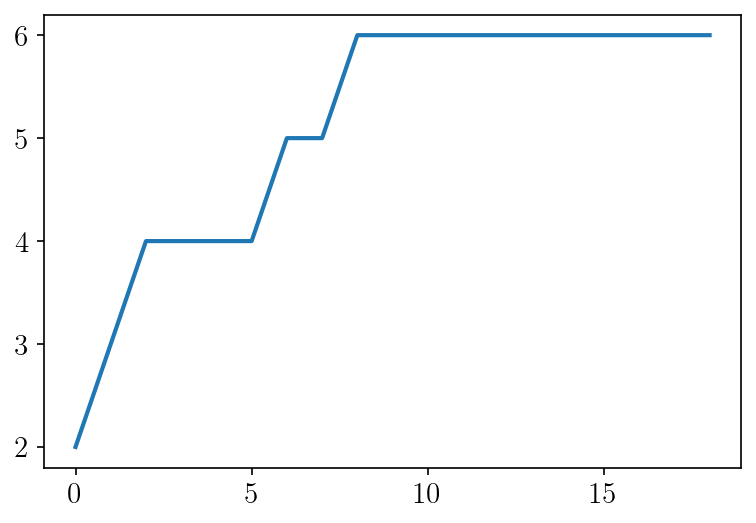

In [18]:
new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
    start_date_string=start_date, end_date_string=end_date)
new_cases = np.ceil(
        (new_cases_ * mob.num_people_unscaled) /
        (mob.downsample * mob.region_population))

plt.plot(new_cases.sum(1))

<b>Instantiate correct state transition distributions (estimated from literature)</b>

In [19]:
distributions = CovidDistributions(country=country)

#### Define helper I/O functions to load/save the output of the experiment

In [20]:
def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

<b>Define initial seed count per state</b>

In [21]:
heuristic_seeds = True

# (a) define heuristically based on true cases and literature distribution estimates
if heuristic_seeds:
    initial_seeds = gen_initial_seeds(new_cases)

# (b) define based state of previous batch of simulations, 
# using the random rollout that best matched the true cases in terms of squared error
else:
    seed_summary_ = load_summary('summary_example.pk')
    seed_day_ = 7
    initial_seeeds = extract_seeds_from_summary(seed_summary_, seed_day_, new_cases)

<b>Set Epidemic Parameters</b>

Need to be calibrated using Bayesian optimization in order to match real case data, but possible to design experiments without calibrated parameters.

In [22]:
beta = 0.50 # this needs to be calibrated

inferred_params = {
    'betas' : {
        'education': beta,
        'office': beta,
        'restaurant': beta,
        'supermarket': beta}, 
    'beta_household' : beta
}

#### Define standard testing parameters

The parameters are the same used for inference

In [23]:
def standard_testing(max_time):
    daily_increase = new_cases.sum(axis=1)[1:] - new_cases.sum(axis=1)[:-1]
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 1 * TO_HOURS,     # in hours
        'test_reporting_lag'  : 2 * TO_HOURS,     # in hours (actual and self-report delay)
        'tests_per_batch'     : int(daily_increase.max()), # test capacity based on empirical positive tests
        'test_fpr'            : 0.0, # test false positive rate
        'test_fnr'            : 0.0, # test false negative rate
        'test_smart_delta'    : 3 * TO_HOURS, # in hours
        'test_smart_duration' : 7 * TO_HOURS, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

# 2. Run the Simulations


Define a helper function to run general type of experiment, fixing all parameters above.

In [24]:
def run(tparam, measure_list, t, local_seeds, dynamic_tracing=False):

    # add standard measure of positives staying isolated
    measure_list +=  [
        SocialDistancingForPositiveMeasure(
            t_window=Interval(0.0, t), p_stay_home=1.0),
        
        SocialDistancingForPositiveMeasureHousehold(
            t_window=Interval(0.0, t), p_isolate=1.0)
    ]
    measure_list = MeasureList(measure_list)

    # run simulations
    summary = launch_parallel_simulations(
        mob_settings, 
        distributions, 
        random_repeats, num_workers, 
        inferred_params, local_seeds, tparam, measure_list, 
        max_time=t, 
        num_people=mob.num_people, 
        num_sites=mob.num_sites, 
        site_loc=mob.site_loc, 
        home_loc=mob.home_loc,
        dynamic_tracing=dynamic_tracing,
        verbose=False)
    return summary

In [25]:
lockdown_at_day = 12

example_measures = [
    
    # education, social sites, and offices close after 1 week
    BetaMultiplierMeasureByType(
        t_window=Interval(lockdown_at_day * TO_HOURS, max_time), 
        beta_multiplier={ 
            'education': 0.0, 
            'office': 0.0, 
            'restaurant': 1.0,
            'supermarket': 1.0
        }),
    
    # less activities of all due to contact constraints after 1 week
    SocialDistancingForAllMeasure(
     t_window=Interval(lockdown_at_day * TO_HOURS, max_time), 
        p_stay_home=0.5)
]

for measure in example_measures:
    print(measure.t_window)
    print(max_time)

Interval(left=288.0, right=456.0)
456.0
Interval(left=288.0, right=456.0)
456.0


In [26]:
testing_params = standard_testing(max_time)
summary_example = run(testing_params, example_measures, max_time, initial_seeds)
save_summary(summary_example, 'summary_example.pk')

d:\softwareinstallation\python\lib\site-packages\numba\core\ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'essential_workers' of function '_simulate_real_mobility_traces'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "lib\mobilitysim.py", line 218:
@numba.njit
def _simulate_real_mobility_traces(*, num_people, max_time, site_type, people_age, mob_rate_per_age_per_type,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


# Emma Exp

### compare 10% compliance for just essential and all

In [28]:
days_future = 12 * 7 # projecting 12 weeks into the future
max_time_future = 24.0 * (days_future)

In [32]:
testing_params_SD_6 = standard_testing(max_time_future)
testing_params_SD_6['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_6['test_smart_action'] = 'isolate'
testing_params_SD_6['test_targets'] = 'isym'
testing_params_SD_6['test_smart_num_contacts'] = 25
isolation_days_SD_6 = 7 # how many days selected people have to stay in isolation
duration_weeks_SD_6 = 12 # strategies tested for 12 weeks starting today

summaries_SD_6 = dict()

# p_compliance = [0.1,0.5,1.0]
p_compliance = [essential_to_total_pop_ratio] #[essential_proportion]
p_compliance_essential = [1.0]
policy = 'basic'

summaries_ = []
testing_params_SD_6['smart_tracing'] = policy
t_window=Interval(*testing_params_SD_6['testing_t_window'])

for p in p_compliance:
    m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_stay_home=1.0, 
                test_smart_duration=24.0 * isolation_days_SD_6),
             ComplianceForAllMeasure(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_compliance=p)]
    
    res = run(testing_params_SD_6, m, max_time_future, initial_seeds) 
    summaries_.append(res)
    print(policy, p, ' all done.')
    
for p_essential in p_compliance_essential:
    m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_stay_home=1.0, 
                test_smart_duration=24.0 * isolation_days_SD_6),
             ComplianceForEssentialWorkers( #ComplianceForEssentialWorkers
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_compliance=p_essential)]
    
    res = run(testing_params_SD_6, m, max_time_future, initial_seeds) 
    summaries_.append(res)
    print(policy, p_essential, ' essen done.')

        
summaries_SD_6[policy] = summaries_

basic 0.12486187845303867  all done.
basic 1.0  essen done.


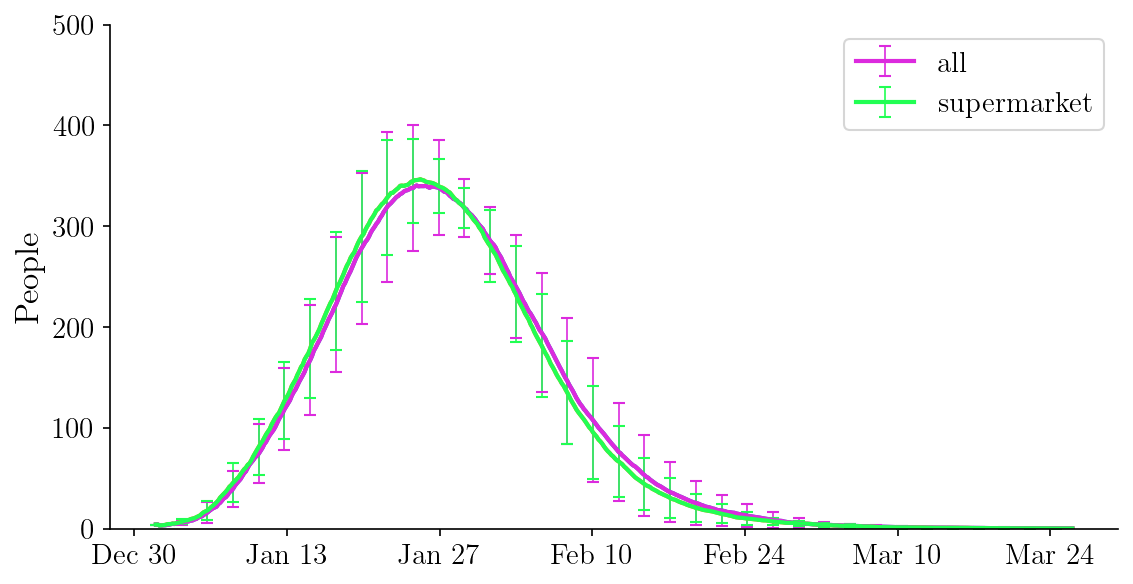

In [33]:
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['all','supermarket']
summaries_ = summaries_SD_6[policy]

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

In [31]:
save_summary(summaries_SD_6, 'summaries_ds'+ str(int(downsample))+'_all'+str((essential_proportion))+'_supermarket' +str((p_essential))+ '_repeats'+str(random_repeats)+'.pk')
summaries_SD_6 = load_summary('summaries_ds'+ str(int(downsample))+'_all'+str((essential_proportion))+'_supermarket' +str((p_essential))+ '_repeats'+str(random_repeats)+'.pk')

### compliance for all

In [ ]:
days_future = 12 * 7 # projecting 12 weeks into the future
max_time_future = 24.0 * (days_future)

In [ ]:
testing_params_SD_6 = standard_testing(max_time_future)
testing_params_SD_6['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_6['test_smart_action'] = 'isolate'
testing_params_SD_6['test_targets'] = 'isym'
testing_params_SD_6['test_smart_num_contacts'] = 25
isolation_days_SD_6 = 7 # how many days selected people have to stay in isolation
duration_weeks_SD_6 = 12 # strategies tested for 12 weeks starting today

summaries_SD_6 = dict()

p_compliance = [0.1,0.5,1.0]
# p_compliance = [0.1]

for policy in ['basic', 'advanced']:
# for policy in ['basic']:
    summaries_ = []
    testing_params_SD_6['smart_tracing'] = policy
    t_window=Interval(*testing_params_SD_6['testing_t_window'])
    for p in p_compliance:

        m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_stay_home=1.0, 
                test_smart_duration=24.0 * isolation_days_SD_6),
             ComplianceForAllMeasure(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_compliance=p)]
#         m = [SocialDistancingForSmartTracing(
#                     t_window=Interval(*testing_params['testing_t_window']), 
#                     p_stay_home=1.0, 
#                     test_smart_duration=24.0 * 7),
#                 ComplianceForAllMeasure(
#                     t_window=Interval(*testing_params['testing_t_window']), 
#                     p_compliance=.08)]
    
        res = run(testing_params_SD_6, m, max_time_future, initial_seeds) 
        summaries_.append(res)

        print(policy, p, ' done.')
        
    summaries_SD_6[policy] = summaries_

In [ ]:
FIGSIZE = (8, 4)
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['basic', 'advanced']):
# for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
#     plotter.compare_total_infections(
#         summaries_, 
#         titles=titles_SD_6_, 
#         figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
#         filename=runstr + f'SD_6{j}', 
#         figsize=FIGSIZE, acc=500, 
#         ymax=40, errorevery=14)
    plotter.compare_total_infections(
    summaries_, 
    titles=titles_SD_6_, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

In [ ]:
save_summary(summaries_SD_6, 'summaries_all_compliant_'+ str(int(downsample)) + '.pk')
summaries_SD_6 = load_summary('summaries_all_compliant_'+ str(int(downsample)) + '.pk')

### compliance for essential workers

In [ ]:
testing_params_SD_6 = standard_testing(max_time_future)
testing_params_SD_6['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_6['test_smart_action'] = 'isolate'
testing_params_SD_6['test_targets'] = 'isym'
testing_params_SD_6['test_smart_num_contacts'] = 25
isolation_days_SD_6 = 7 # how many days selected people have to stay in isolation
duration_weeks_SD_6 = 12 # strategies tested for 12 weeks starting today

summaries_SD_6 = dict()

p_compliance = [0.1,0.5,1.0]
# p_compliance = [0.1]

for policy in ['basic', 'advanced']:
# for policy in ['basic']:
    summaries_ = []
    testing_params_SD_6['smart_tracing'] = policy
    t_window=Interval(*testing_params_SD_6['testing_t_window'])
    for p in p_compliance:

        m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_stay_home=1.0, 
                test_smart_duration=24.0 * isolation_days_SD_6),
             ComplianceForEssentialWorkers(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_compliance=p)]
#         m = [SocialDistancingForSmartTracing(
#                     t_window=Interval(*testing_params['testing_t_window']), 
#                     p_stay_home=1.0, 
#                     test_smart_duration=24.0 * 7),
#                 ComplianceForAllMeasure(
#                     t_window=Interval(*testing_params['testing_t_window']), 
#                     p_compliance=.08)]
    
        res = run(testing_params_SD_6, m, max_time_future, initial_seeds) 
        summaries_.append(res)

        print(policy, p, ' done.')
        
    summaries_SD_6[policy] = summaries_

In [ ]:
FIGSIZE = (8, 4)
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['basic', 'advanced']):
# for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
#     plotter.compare_total_infections(
#         summaries_, 
#         titles=titles_SD_6_, 
#         figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
#         filename=runstr + f'SD_6{j}', 
#         figsize=FIGSIZE, acc=500, 
#         ymax=40, errorevery=14)
    plotter.compare_total_infections(
    summaries_, 
    titles=titles_SD_6_, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

In [ ]:
save_summary(summaries_SD_6, 'summaries_essen_compliant_'+ str(int(downsample)) + '.pk')
summaries_SD_6 = load_summary('summaries_essen_compliant_'+ str(int(downsample)) + '.pk')

# Experiments for CEE218Z

## Social Distancing For Smart Tracing For All

In [ ]:
testing_params = standard_testing(max_time)

In [ ]:
measure_list = [SocialDistancingForSmartTracing(
                    t_window=Interval(*testing_params['testing_t_window']), 
                    p_stay_home=1.0, 
                    test_smart_duration=24.0 * 7),
                ComplianceForAllMeasure(
                    t_window=Interval(*testing_params['testing_t_window']), 
                    p_compliance=.08)]

# summary_INF = run(testing_params_opt, measure_list, max_time_present, initial_seeds)

summary_INF = run(testing_params, measure_list, max_time, initial_seeds)

save_summary(summary_INF, 'summary_ST_all.pk')
summary_INF = load_summary('summary_ST_all.pk')

In [ ]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summaries_, new_cases.sum(axis=1), 
    title='Example', 
    filename=runstr + 'ex_00',
    figsize=(6, 4),
    start_date=start_date,
    errorevery=1, acc=1000, 
    lockdown_at=lockdown_at_day,
    ymax=50)

In [ ]:
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])

for j, policy in enumerate(['basic', 'advanced']):
# for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
    summaries_, 
    titles=titles_SD_6_, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=400, errorevery=14)

In [ ]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_INF, new_cases.sum(axis=1), 
    test_lag=2,
    title=('Predictions for uncontrolled scenario after March 23'
           'for inferred parameters'), 
    filename=runstr + 'opt_00',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=1000)

In [ ]:
# compliances = [.1, .25, .50, 1.0]
compliances = [.1, 1.0]

summaries_ST_all = []
for j, cmpl in enumerate(compliances):
    
    # same as tuned before but continued for longer
    m = [SocialDistancingForSmartTracing(
                    t_window=Interval(*testing_params_opt['testing_t_window']), 
                    p_stay_home=1.0, 
                    test_smart_duration=24.0 * 7),
                ComplianceForAllMeasure(
                    t_window=Interval(*testing_params_opt['testing_t_window']), 
                    p_compliance=cmpl)] 

    res = run(testing_params_opt, m, max_time_present, initial_seeds) 
    summaries_ST_all.append(res)
    print(f'Smart Tracing for All compliance {cmpl} done.')

save_summary(summaries_ST_all, 'summaries_ST_all.pk')
summaries_ST_all = load_summary('summaries_ST_all.pk')

In [ ]:
titles_ST_all = [f"Compliance {cmpl}" for cmpl in compliances]
plotter.compare_total_infections(
    summaries_ST_all, 
    titles=titles_ST_all, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

### Social Distancing For Smart Tracing For Essential Workers

In [ ]:
compliances = [.1, .25, .50, 1.0]
summaries_ST_essential = []
for j, cmpl in enumerate(compliances):
    
    # same as tuned before but continued for longer
    m = [SocialDistancingForSmartTracing(
                    t_window=Interval(*testing_params_opt['testing_t_window']), 
                    p_stay_home=1.0, 
                    test_smart_duration=24.0 * 7),
                ComplianceForEssentialWorkers(
                    t_window=Interval(*testing_params_opt['testing_t_window']), 
                    p_compliance=cmpl)] 

    res = run(testing_params_opt, m, max_time_present, initial_seeds) 
    summaries_ST_essential.append(res)
    print(f'Smart Tracing for essential workers compliance {cmpl} done.')

save_summary(summaries_ST_essential, 'summaries_ST_essential.pk')
summaries_ST_essential = load_summary('summaries_ST_essential.pk')

In [ ]:
titles_ST_all = [f"Compliance {cmpl}" for cmpl in compliances]
plotter.compare_total_infections(
    summaries_ST_all, 
    titles=titles_ST_all, 
    figtitle=r'Contact Tracing Case Isolation for Essential Workers',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

## Contact Tracing for Essential, Shelter In-Place for NonEssential

In [ ]:
# compliances = [.1, .25, .50, 1.0]
p_stay_homes = [.1, .25, .50, 1.0]
summaries_ST_SD = []
for j, phome in enumerate(p_stay_homes):
    m = [SocialDistancingForSmartTracing(
            t_window=Interval(*testing_params_opt['testing_t_window']), 
            p_stay_home=1.0, 
            test_smart_duration=24.0 * 7),
        ComplianceForEssentialWorkers(
            t_window=Interval(*testing_params_opt['testing_t_window']), 
            p_compliance=1.0),
        SocialDistancingForNonEssential(
            t_window=Interval(*testing_params_opt['testing_t_window']),
            p_stay_home=phome)
        ] 

    res = run(testing_params_opt, m, max_time_present, initial_seeds) 
    summaries_ST_SD.append(res)
    print(f'SmartTracingEssential/DistancingNonEssential, NonEssential p_stay_home = {phome} (Essential compliance=1.0, esential p_stay_home=1.0) done.')

save_summary(summaries_ST_SD, 'summaries_ST_SD.pk')
summaries_ST_SD = load_summary('summaries_ST_SD.pk')

In [ ]:
titles_ST_SD = [f"pstayhome {phome}" for phome in p_stay_homes]
plotter = Plotter()
plotter.compare_total_infections(
    summaries_ST_SD, 
    titles=titles_ST_SD, 
    figtitle=r'ST Essential, SD NonEssential',
    filename=runstr + 'ST_SD', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

## Just Social Distancing

In [ ]:
testing_params_opt = standard_testing(max_time_present)
measure_list = [SocialDistancingForAllMeasure(
                    t_window=Interval(*testing_params_opt['testing_t_window']), 
                    p_stay_home=.1)]

summary_INF = run(testing_params_opt, measure_list, max_time_present, initial_seeds)

save_summary(summary_INF, 'summary_INF.pk')
summary_INF = load_summary('summary_INF.pk')

In [ ]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_INF, new_cases.sum(axis=1), 
    test_lag=2,
    title=('Predictions for uncontrolled scenario after March 23'
           'for inferred parameters'), 
    filename=runstr + 'opt_00',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=1000)

In [ ]:
p_stay_homes = [.1, .2, .3]
summaries_SD_all = []
for j, phome in enumerate(p_stay_homes):
    m = [SocialDistancingForAllMeasure(
            t_window=Interval(*testing_params_opt['testing_t_window']),
            p_stay_home=phome)
        ] 

    res = run(testing_params_opt, m, max_time_present, initial_seeds) 
    summaries_SD_all.append(res)
    print(f'SocialDistancingForAllMeasure, p_stay_home={phome} done.')

save_summary(summaries_SD_all, 'summaries_SD_all.pk')
summaries_ST_all = load_summary('summaries_SD_all.pk')

In [ ]:
summaries_SD_all = load_summary('summaries_SD_all.pk')
summary_INF = summaries_SD_all[2]
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_INF, new_cases.sum(axis=1), 
    test_lag=2,
    title=('Predictions for uncontrolled scenario after March 23'
           'for inferred parameters'), 
    filename=runstr + 'opt_00',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=1000)

In [ ]:
titles_SD_all = [f"pstayhome {phome}" for phome in p_stay_homes]
plotter = Plotter()
plotter.compare_total_infections(
    summaries_SD_all, 
    titles=titles_SD_all, 
    figtitle=r'Social Distancing For All',
    filename=runstr + 'SD_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

In [ ]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summaries_SD_all[0], new_cases.sum(axis=1), 
    test_lag=2,
    title=('Predictions for uncontrolled scenario after March 23'
           'for inferred parameters'), 
    filename=runstr + 'opt_00',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=1000)

## No Measures

In [ ]:
# testing_params_opt = standard_testing(max_time_present)
# measure_list = [SocialDistancingForSmartTracing(
#                     t_window=Interval(*testing_params_opt['testing_t_window']), 
#                     p_stay_home=1.0, 
#                     test_smart_duration=24.0 * 7),
#                ComplianceForEssentialWorkers(
#                     t_window=Interval(*testing_params_opt['testing_t_window']), 
#                     p_compliance=1.0)]

# summary_INF = run(testing_params_opt, measure_list, max_time_present, initial_seeds)

# save_summary(summary_INF, 'summary_ST_basic_essential.pk')
# summary_INF = load_summary('summary_ST_basic_essential.pk')

In [ ]:
plotter.plot_daily_infected(
    summary_INF,
    title='Infections by type for uncontrolled scenario after March 23', 
    filename=runstr + 'opt_001',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    show_target=new_cases.sum(axis=1),
    ymax=1500)


In [ ]:
plotter.plot_Rt_types(
    summary_INF,
    title='Reproductive rate by contribution for uncontrolled scenario after March 23', 
    filename=runstr + 'opt_002',
    figsize=FIGSIZE,
    errorevery=1, 
    estimation_window=3 * 24.0)

In [ ]:
plt.close()

### 4.3.4. Can we control the outbreak using only contact tracing and isolation?

In [ ]:
testing_params_SD_5 = standard_testing(max_time_future)
testing_params_SD_5['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_5['test_smart_action'] = 'isolate'
testing_params_SD_5['test_targets'] = 'isym'

isolation_days = [3, 7] # how many days selected people have to stay in isolation
contacts_isolated = [10, 25] # how many contacts are isolated in the `test_smart_delta` window
duration_weeks_SD_5 = 12 # strategies tested for 12 weeks starting today

summaries_SD_5 = dict()

In [ ]:
# baseline taken from above
for days in isolation_days:
    for contacts in contacts_isolated:
        summaries_SD_5[(days, contacts)] = [future_baseline]


# Isolation strategies
for days in isolation_days:
    for contacts in contacts_isolated:
        for policy in ['basic', 'advanced']:

            testing_params_SD_5['smart_tracing'] = policy
            testing_params_SD_5['test_smart_num_contacts'] = contacts


            # same as tuned plus different isolation strategies for contact tracing
            m = [SocialDistancingForSmartTracing(
                    t_window=Interval(*testing_params_SD_5['testing_t_window']), 
                    p_stay_home=1.0, 
                    test_smart_duration=24.0 * days)
            ]

            res = run(testing_params_SD_5, m, max_time_future, present_seeds) 
            summaries_SD_5[(days, contacts)].append(res)
            
            print(days, contacts, policy, ' done.')


In [ ]:
save_summary(summaries_SD_5, 'summaries_SD_5.pk')
summaries_SD_5 = load_summary('summaries_SD_5.pk')

In [ ]:
plotter = Plotter()

for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        plotter.compare_total_infections(
            summaries_, 
            titles=titles_SD_5_, 
            figtitle=(f'Strategies for isolating {contacts} contacts.\n'
                      f'Selected people are isolated for {days} days.'),
            filename=runstr + f'SD_5{i}{j}', 
            figsize=FIGSIZE, acc=500, 
            ymax=300, errorevery=14)

In [ ]:
plotter = Plotter()

for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        for k, titl in enumerate(titles_SD_5_):
            plotter.plot_daily_at_home(
                summaries_[k],
                title='Home isolation for ' + titl, 
                filename=runstr + f'SD_6{i}{j}{k}', figsize=FIGSIZE, 
                errorevery=14, acc=500)

In [ ]:
plt.close()

### 4.3.5. Effects  of compliance on the efficacy of isolation for smart  tracing strategies

In [ ]:
testing_params_SD_6 = standard_testing(max_time_future)
testing_params_SD_6['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_6['test_smart_action'] = 'isolate'
testing_params_SD_6['test_targets'] = 'isym'
testing_params_SD_6['test_smart_num_contacts'] = 25
isolation_days_SD_6 = 7 # how many days selected people have to stay in isolation
duration_weeks_SD_6 = 12 # strategies tested for 12 weeks starting today

summaries_SD_6 = dict()

p_compliance = [0.1, 0.25, 0.5, 1.0] 

for policy in ['basic', 'advanced']:
    summaries_ = []
    testing_params_SD_6['smart_tracing'] = policy
    
    for p in p_compliance:

        m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_stay_home=1.0, 
                test_smart_duration=24.0 * isolation_days_SD_6),
             ComplianceForAllMeasure(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_compliance=p)
        ]
        res = run(testing_params_SD_6, m, max_time_future, present_seeds) 
        summaries_.append(res)

        print(policy, p, ' done.')
        
    summaries_SD_6[policy] = summaries_

In [ ]:
save_summary(summaries_SD_6, 'summaries_SD_6.pk')
summaries_SD_6 = load_summary('summaries_SD_6.pk')

In [ ]:
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['basic', 'advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=200, errorevery=14)
   

In [ ]:
plt.close()